In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from importlib import reload
import pandas as pd
import matplotlib
import numpy as np
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from src.constants import PROCESSED_POLCOM_DATA_2022_M_PATH, PROCESSED_POLCOM_DATA_2022_Y_PATH, PROCESSED_AZURE_DATA_PATH
from src.utils import concat_dataframes_horizontally

In [3]:
dfs_M = {file.name: pd.read_parquet(file) for file in Path(PROCESSED_POLCOM_DATA_2022_M_PATH).glob("*.parquet")}
dfs_Y = {file.name: pd.read_parquet(file) for file in Path(PROCESSED_POLCOM_DATA_2022_Y_PATH).glob("*.parquet")}

In [4]:
list(dfs_M.items())[2]

('VM07.parquet',
                      CPU_USAGE_MHZ  CPU_USAGE_PERCENT  MEMORY_USAGE_KB  \
 DATE                                                                     
 2022-03-14 10:00:00        50549.0               28.0              NaN   
 2022-03-14 12:00:00        49843.0               27.0     1.816727e+09   
 2022-03-14 14:00:00        44727.0               24.0     1.816723e+09   
 2022-03-14 16:00:00        44258.0               24.0     1.816720e+09   
 2022-03-14 18:00:00        43164.0               23.0     1.816729e+09   
 ...                            ...                ...              ...   
 2022-03-10 00:00:00            NaN                NaN              NaN   
 2022-03-11 00:00:00            NaN                NaN              NaN   
 2022-03-12 00:00:00            NaN                NaN              NaN   
 2022-03-13 00:00:00            NaN                NaN              NaN   
 2022-03-14 00:00:00            NaN                NaN              NaN   
 
      

In [5]:
def filter_cpu_absolute(cols):
    return [col for col in cols if ("CPU" in col) and "PERCENT" not in col]

# Apply filtering to keep only absolute CPU usage (MHz) metrics
cpu_absolute_only_dfs_M = {file: df[filter_cpu_absolute(df.columns)] for file, df in dfs_M.items()}
cpu_absolute_only_dfs_Y = {file: df[filter_cpu_absolute(df.columns)] for file, df in dfs_Y.items()}

In [6]:
remaining_columns_M = {file: df.columns.tolist() for file, df in cpu_absolute_only_dfs_M.items()}
remaining_columns_Y = {file: df.columns.tolist() for file, df in cpu_absolute_only_dfs_Y.items()}

remaining_columns_M, remaining_columns_Y

({'VM06.parquet': ['CPU_USAGE_MHZ'],
  'VM03.parquet': ['CPU_USAGE_MHZ'],
  'VM07.parquet': ['CPU_USAGE_MHZ'],
  'VM08.parquet': ['CPU_USAGE_MHZ'],
  'VM04.parquet': ['CPU_USAGE_MHZ'],
  'VM01.parquet': ['CPU_USAGE_MHZ'],
  'VM02.parquet': ['CPU_USAGE_MHZ'],
  'VM05.parquet': ['CPU_USAGE_MHZ']},
 {'VM06.parquet': ['CPU_USAGE_MHZ'],
  'VM03.parquet': ['CPU_USAGE_MHZ'],
  'VM07.parquet': ['CPU_USAGE_MHZ'],
  'VM08.parquet': ['CPU_USAGE_MHZ'],
  'VM04.parquet': ['CPU_USAGE_MHZ'],
  'VM01.parquet': ['CPU_USAGE_MHZ'],
  'VM02.parquet': ['CPU_USAGE_MHZ'],
  'VM05.parquet': ['CPU_USAGE_MHZ']})

In [7]:
cpu_absolute_only_dfs_M

{'VM06.parquet':                      CPU_USAGE_MHZ
 DATE                              
 2022-03-14 12:00:00        58567.0
 2022-03-14 14:00:00        41881.0
 2022-03-14 16:00:00        31048.0
 2022-03-14 18:00:00        34468.0
 2022-03-14 20:00:00        31933.0
 ...                            ...
 2022-03-10 00:00:00            NaN
 2022-03-11 00:00:00            NaN
 2022-03-12 00:00:00            NaN
 2022-03-13 00:00:00            NaN
 2022-03-14 00:00:00            NaN
 
 [695 rows x 1 columns],
 'VM03.parquet':                      CPU_USAGE_MHZ
 DATE                              
 2022-03-13 14:00:00        60035.0
 2022-03-13 16:00:00        59883.0
 2022-03-13 18:00:00        57655.0
 2022-03-13 20:00:00        50277.0
 2022-03-13 22:00:00        53088.0
 ...                            ...
 2022-03-09 00:00:00            NaN
 2022-03-10 00:00:00            NaN
 2022-03-11 00:00:00            NaN
 2022-03-12 00:00:00            NaN
 2022-03-13 00:00:00            NaN
 
 [6

In [8]:
for file, df in cpu_absolute_only_dfs_M.items():
    df.index = pd.to_datetime(df.index)
    df.index.sort_values()

In [9]:
split_datasets = {}

# Iterate over each VM dataset
for vm, df in cpu_absolute_only_dfs_M.items():
    for col in df.columns:
        # Create a new dataframe for each column and rename the column to a predefined name
        split_df = df[[col]].rename(columns={col: 'METRIC_VALUE'})
        split_datasets[f"{vm}_{col}"] = split_df

In [10]:
cpu_absolute_only_dfs_M = split_datasets

In [11]:
#min_date = max(df.index.min() for df in cpu_absolute_only_dfs_M.values())
#max_date = min(df.index.max() for df in cpu_absolute_only_dfs_M.values())

#print(f"Common Time Range: {min_date} to {max_date}")


In [12]:
#df_combined = pd.concat(cpu_absolute_only_dfs_M.values(), axis=1, keys=cpu_absolute_only_dfs_M.keys())

# Rename columns to show which VM they belong to
#df_combined.columns = [f"{vm}_{col}" for vm, col in df_combined.columns]

# Display result
#df_combined


In [13]:
# Updated function to remove both NaNs and leading/trailing zeros while preserving gaps in the middle
def trim_nan_and_zero_edges(df):
    """Removes NaN and zero values only at the beginning and end of a DataFrame while preserving gaps in the middle."""
    first_valid_idx = df[(df.notna()) & (df != 0)].first_valid_index()
    last_valid_idx = df[(df.notna()) & (df != 0)].last_valid_index()
    return df.loc[first_valid_idx:last_valid_idx]

# Apply trimming to each VM dataset
cpu_trimmed_dfs_M = {vm: trim_nan_and_zero_edges(df) for vm, df in cpu_absolute_only_dfs_M.items()}

# Verify results: Check if NaN and zero values at the edges were removed
zero_nan_summary = {vm: (df.isin([0]).sum().sum(), df.isna().sum().sum(), df.index.min(), df.index.max()) for vm, df in cpu_trimmed_dfs_M.items()}
zero_nan_summary


{'VM06.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-14 12:00:00'),
  Timestamp('2022-04-13 06:00:00')),
 'VM03.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-13 14:00:00'),
  Timestamp('2022-04-12 08:00:00')),
 'VM07.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-14 10:00:00'),
  Timestamp('2022-04-13 06:00:00')),
 'VM08.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-14 10:00:00'),
  Timestamp('2022-04-13 04:00:00')),
 'VM04.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-13 14:00:00'),
  Timestamp('2022-04-12 08:00:00')),
 'VM01.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-14 12:00:00'),
  Timestamp('2022-04-13 08:00:00')),
 'VM02.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-14 14:00:00'),
  Timestamp('2022-04-13 08:00:00')),
 'VM05.parquet_CPU_USAGE_MHZ': (0,
  0,
  Timestamp('2022-03-13 14:00:00'),
  Timestamp('2022-04-12 08:00:00'))}

In [14]:
len(cpu_trimmed_dfs_M)

8

In [15]:
# remove dataset if it contains any NaN values
cpu_trimmed_dfs_M = {vm: df for vm, df in cpu_trimmed_dfs_M.items() if df.isna().sum().sum() == 0}

In [16]:
len(cpu_trimmed_dfs_M)

8

In [17]:
cpu_trimmed_dfs_M

{'VM06.parquet_CPU_USAGE_MHZ':                      METRIC_VALUE
 DATE                             
 2022-03-14 12:00:00       58567.0
 2022-03-14 14:00:00       41881.0
 2022-03-14 16:00:00       31048.0
 2022-03-14 18:00:00       34468.0
 2022-03-14 20:00:00       31933.0
 ...                           ...
 2022-04-12 22:00:00       35485.0
 2022-04-13 00:00:00       40423.0
 2022-04-13 02:00:00       33106.0
 2022-04-13 04:00:00       37600.0
 2022-04-13 06:00:00       59916.0
 
 [358 rows x 1 columns],
 'VM03.parquet_CPU_USAGE_MHZ':                      METRIC_VALUE
 DATE                             
 2022-03-13 14:00:00       60035.0
 2022-03-13 16:00:00       59883.0
 2022-03-13 18:00:00       57655.0
 2022-03-13 20:00:00       50277.0
 2022-03-13 22:00:00       53088.0
 ...                           ...
 2022-04-12 00:00:00       85847.0
 2022-04-12 02:00:00       87466.0
 2022-04-12 04:00:00      110286.0
 2022-04-12 06:00:00      138615.0
 2022-04-12 08:00:00      139214.0
 
 

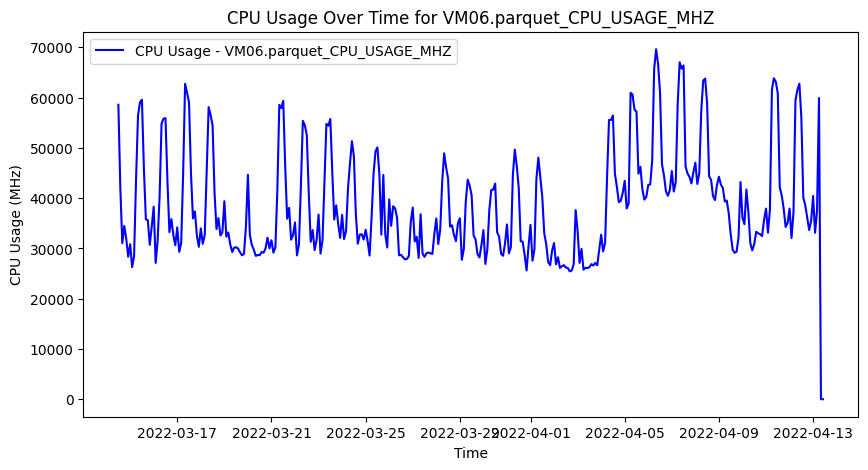

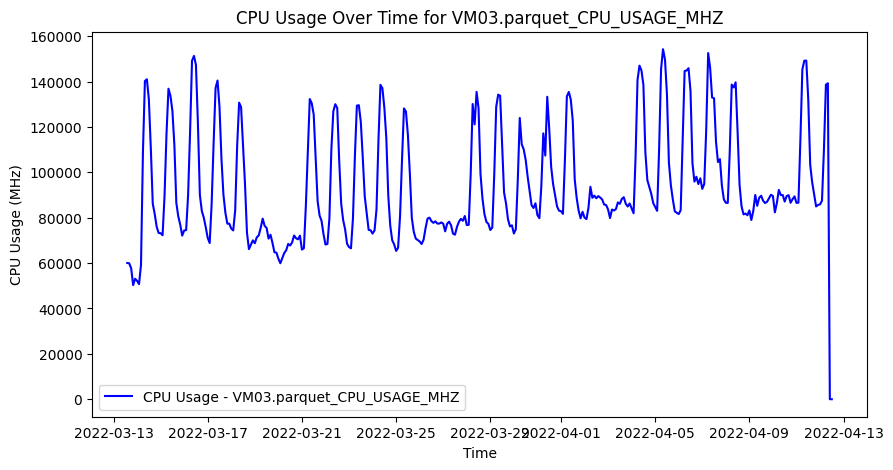

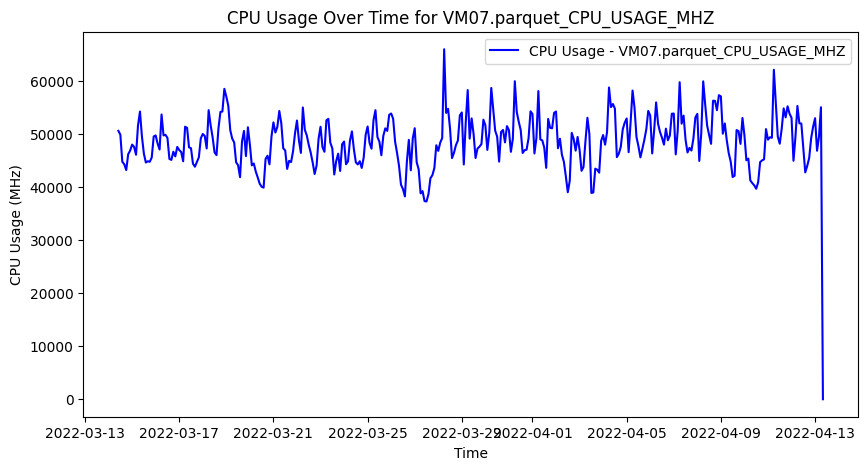

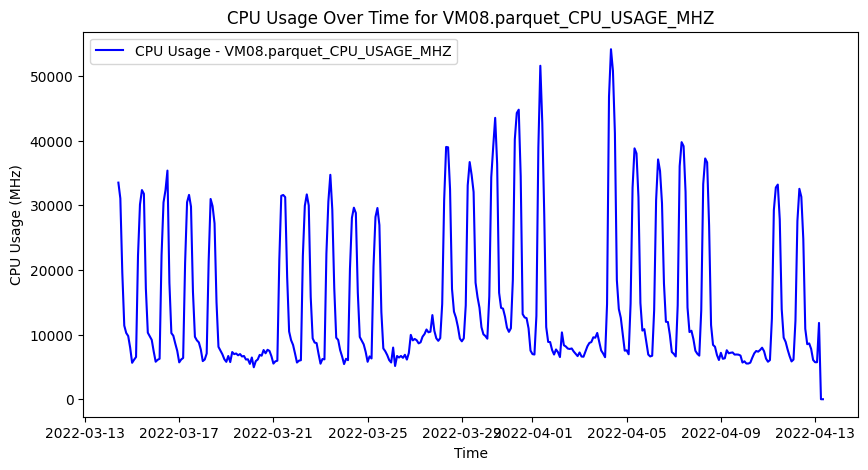

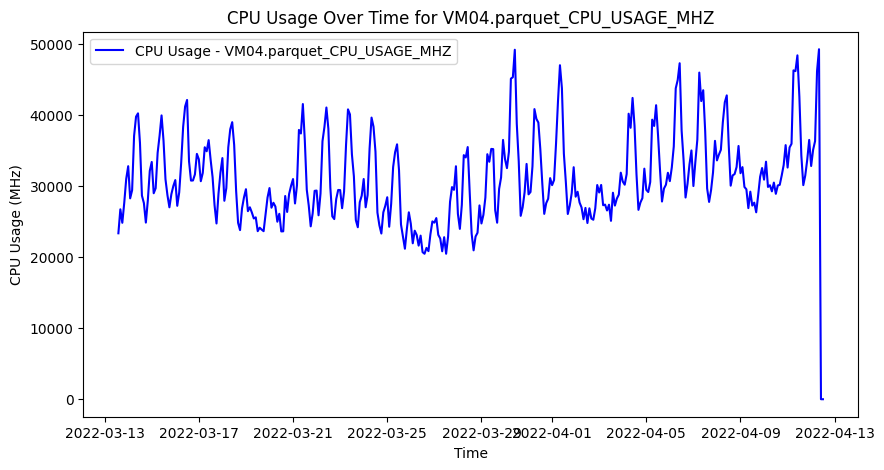

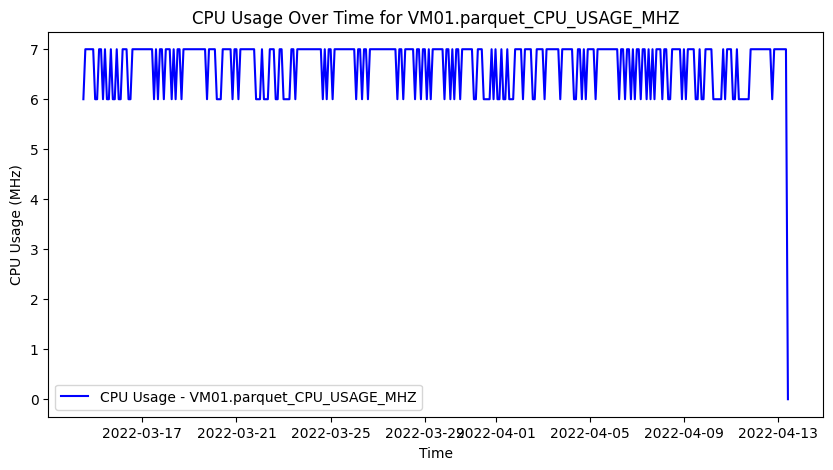

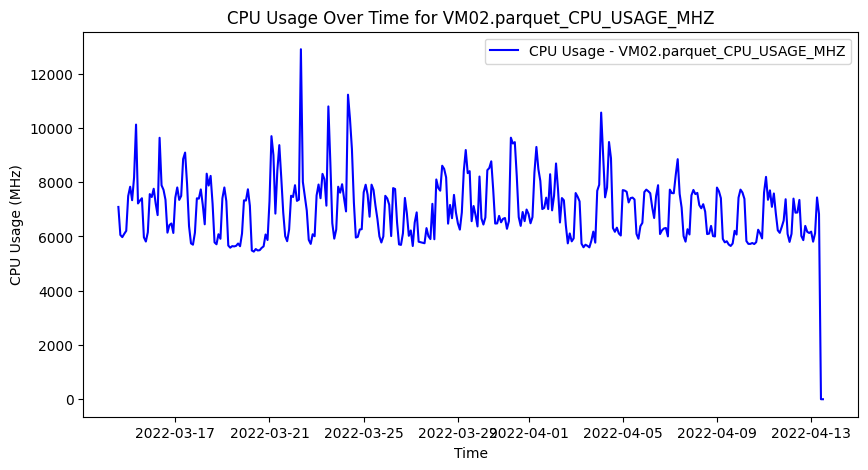

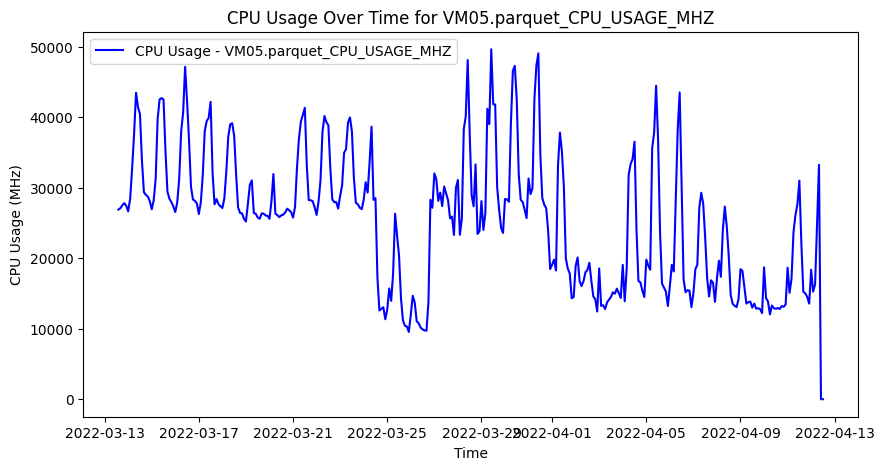

In [18]:
# Plot each VM's CPU usage separately
for vm, df in cpu_absolute_only_dfs_M.items():
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df["METRIC_VALUE"], label=f"CPU Usage - {vm}", color="blue")
    plt.xlabel("Time")
    plt.ylabel("CPU Usage (MHz)")
    plt.title(f"CPU Usage Over Time for {vm}")
    plt.legend()
    plt.show()

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def create_multi_step_sequences(data, seq_length=10, forecast_horizon=5):
    """Convert time series into sequences for multi-step forecasting."""
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data.iloc[i:i+seq_length].values)  # Input sequence (all features)
        y.append(data.iloc[i+seq_length:i+seq_length+forecast_horizon, 0].values)  # Predict METRIC_VALUE only
    return np.array(X), np.array(y)

def add_time_features(df):
    """Add time-related features to a dataframe indexed by timestamps."""
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)  # 1 for Sat/Sun

    # Encode cyclical time features
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    df["dayofweek_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dayofweek_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    return df[["METRIC_VALUE", "hour_sin", "hour_cos", "dayofweek_sin", "dayofweek_cos", "month_sin", "month_cos", "is_weekend"]]

# Define sequence length and horizon
seq_length = 30
forecast_horizon = 30

X_train_list, y_train_list = [], []

for vm, df in cpu_trimmed_dfs_M.items():
    # Add time-based features
    df_with_time_features = add_time_features(df)

    # Normalize all features
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df_with_time_features)

    # Convert to DataFrame with proper index
    df_scaled = pd.DataFrame(df_scaled, index=df.index, columns=df_with_time_features.columns)

    # Create sequences
    X, y = create_multi_step_sequences(df_scaled, seq_length, forecast_horizon)

    X_train_list.append(X)
    y_train_list.append(y)

# Combine all sequences into a single training dataset
X_train = np.vstack(X_train_list)
y_train = np.vstack(y_train_list)

print("Final Training Shape:", X_train.shape, y_train.shape)



Final Training Shape: (2394, 30, 8) (2394, 30)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten

# Define the CNN-LSTM model with correct output shape
def build_model(seq_length, forecast_horizon, num_features):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(seq_length, num_features)),
        LSTM(64, return_sequences=False),
        Dense(128, activation="relu"),
        Dense(forecast_horizon, activation="linear")  # Only predicting `METRIC_VALUE`
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

# Train the model on all VM data
num_features = X_train.shape[-1]  # Now includes time features, but they are inputs only
model = build_model(seq_length, forecast_horizon, num_features)
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


2025-03-03 10:39:01.876829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-03 10:39:01.876874: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-03-03 10:39:03.750002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-03 10:39:03.750211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-03 10:39:03.750284: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcub

Epoch 1/10
75/75 [==============================] - 3s 18ms/step - loss: 0.0815
Epoch 2/10
75/75 [==============================] - 1s 17ms/step - loss: 0.0569
Epoch 3/10
75/75 [==============================] - 1s 17ms/step - loss: 0.0508
Epoch 4/10
75/75 [==============================] - 1s 18ms/step - loss: 0.0474
Epoch 5/10
75/75 [==============================] - 1s 19ms/step - loss: 0.0455
Epoch 6/10
75/75 [==============================] - 2s 21ms/step - loss: 0.0432
Epoch 7/10
75/75 [==============================] - 2s 27ms/step - loss: 0.0420
Epoch 8/10
75/75 [==============================] - 1s 20ms/step - loss: 0.0407
Epoch 9/10
75/75 [==============================] - 1s 19ms/step - loss: 0.0399
Epoch 10/10
75/75 [==============================] - 2s 21ms/step - loss: 0.0388


Azure Test Data Shape: (301, 30, 8)
10/10 [==============================] - 0s 7ms/step
Predicted CPU usage (normalized) for next 30 steps: [[0.6924735  0.7106528  0.531083   ... 0.48180944 0.38714695 0.38667816]
 [0.5939779  0.57068044 0.40930352 ... 0.4101606  0.3621033  0.3859488 ]
 [0.47652543 0.44550094 0.36357424 ... 0.36261925 0.35449603 0.38899127]
 ...
 [0.24515414 0.17295656 0.2005995  ... 0.59973496 0.58538145 0.47060508]
 [0.21343128 0.22064143 0.24388021 ... 0.62557006 0.57316315 0.48495772]
 [0.2311656  0.28551322 0.28676498 ... 0.5981981  0.52471995 0.46734294]]


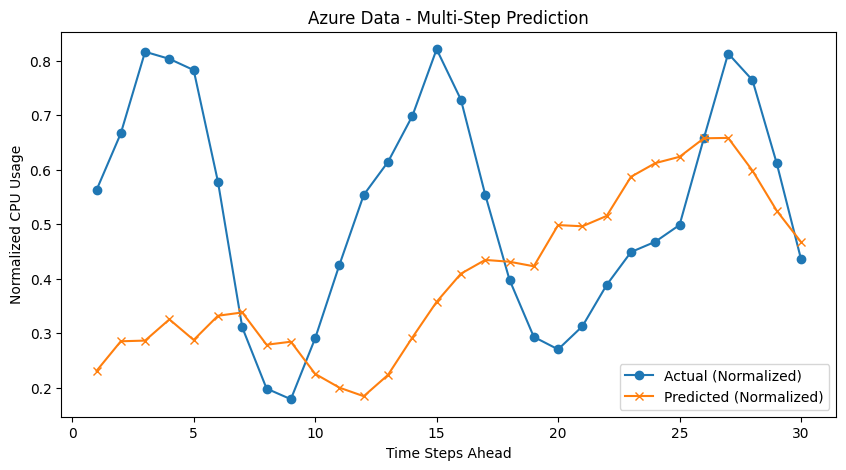

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load Azure CSV with timestamp parsing
df = pd.read_csv(f'{PROCESSED_AZURE_DATA_PATH}azure.csv', parse_dates=['timestamp'])

# Clean column names: "avg cpu" → "avg_cpu"
df.columns = df.columns.str.strip().str.replace(' ', '_')

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Resample data to 2-hour intervals (mean aggregation)
df_resampled = df.resample('2H').mean().dropna()

# ✅ Add time-based features (same as training)
def add_time_features(df):
    """Generate time-based features."""
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)  # 1 if weekend

    # Cyclical encoding
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    df["dayofweek_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dayofweek_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    return df[["avg_cpu", "hour_sin", "hour_cos", "dayofweek_sin", "dayofweek_cos", "month_sin", "month_cos", "is_weekend"]]

# Apply time feature transformation
df_features = add_time_features(df_resampled)

# ✅ Scale features using the same scaler from training
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_features)

# Convert back to DataFrame
df_scaled_df = pd.DataFrame(df_scaled, index=df_resampled.index, columns=df_features.columns)

# ✅ Create test sequences (but only predict avg_cpu)
X_test, _ = create_multi_step_sequences(df_scaled_df, seq_length, forecast_horizon)

print("Azure Test Data Shape:", X_test.shape)

# ✅ Make Predictions
y_pred = model.predict(X_test)

print(f"Predicted CPU usage (normalized) for next {forecast_horizon} steps:", y_pred)

# ✅ Select the last sequence's prediction
y_pred_last = y_pred[-1]  # Last predicted sequence (forecast_horizon,)

# ✅ Select the corresponding last actual values (only `avg_cpu`)
y_actual_last = df_scaled_df["avg_cpu"].iloc[-forecast_horizon:].values  # Match forecast_horizon

# ✅ Plot predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(range(1, forecast_horizon + 1), y_actual_last, label="Actual (Normalized)", marker="o")
plt.plot(range(1, forecast_horizon + 1), y_pred_last, label="Predicted (Normalized)", marker="x")
plt.xlabel("Time Steps Ahead")
plt.ylabel("Normalized CPU Usage")
plt.title("Azure Data - Multi-Step Prediction")
plt.legend()
plt.show()
